In [1]:
#xyzファイルのインポート
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

with open("C:/Users/kozo/Documents/PYTHON/Least_squares/jupyter_notebook/ati_1_1_out-Cloud.xyz", "r") as inf:
    iary = inf.readlines()

N = len(iary)
xyz = np.zeros((N, 3))

for i, ary in enumerate(iary):
    ary = ary.replace("\n", "")
    data = ary.split(" ")
    u, m, p = float(data[0]), float(data[1]), float(data[2])
    xyz[i] = [u, m, p]
    
#座標ごとの配列に転置
x, y, z = xyz.T

#座標ごとの最大値、最小値
ixyz = np.array([np.max(x), np.min(x), np.max(y), np.min(y), np.max(z), np.min(z)])
#座標ごとの点群の最大距離
lexyz = np.array([np.abs(ixyz[0] - ixyz[1]), np.abs(ixyz[2] - ixyz[3]), np.abs(ixyz[4] - ixyz[5])])

#yz平面データ
print("N: %d" %(N))
print("\npcd :")
print(xyz)

#グラフ描写
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.scatter3D(x, y, z, label="Dataset", s=0.3)
plt.show()


N: 63324

pcd :
[[-3785.57202148 -2359.83178711  -613.86199951]
 [-3713.078125   -2335.63647461  -613.91009521]
 [-3711.13012695 -2336.84838867  -614.14752197]
 ...
 [-3540.62255859 -2238.66943359  -625.94769287]
 [-3544.13623047 -2234.37744141  -623.00097656]
 [-3545.47070313 -2239.26318359  -624.76580811]]


<Figure size 640x480 with 1 Axes>

In [2]:
def inertial_coordinates(x, y, z, N):

    #重心
    G = np.zeros(3)
    G = [np.average(x), np.average(y), np.average(z)]

    print("G: (%f, %f, %f)" %(G[0], G[1], G[2]))

    #各慣性モーメント
    I = np.zeros(6) #ixx, iyy, izz, ixy, iyz, izx
    for i in range(N):
        I[0] += (x[i] - G[0])**2
        I[1] += (y[i] - G[1])**2
        I[2] += (z[i] - G[2])**2
        I[3] += (x[i] - G[0])*(y[i] - G[1])
        I[4] += (y[i] - G[1])*(z[i] - G[2])
        I[5] += (z[i] - G[2])*(x[i] - G[0])

    #慣性テンソル
    A = np.zeros((3, 3))
    A = [[I[0], I[3], I[5]],
         [I[3], I[1], I[4]],
         [I[5], I[4], I[2]]]

    print("\n慣性テンソル:")
    print(A[0])
    print(A[1])
    print(A[2])

    #固有値Wと固有ベクトルV
    W, V = np.zeros(3), np.zeros((3, 3))
    W, V = np.linalg.eig(A)
    V = V.T
    V_inv = np.linalg.inv(V) #逆行列

    print("\n固有値:")
    print(W)
    print("\n固有ベクトル:")
    print(V)

    #基準となるベクトル（固有値が最大となる固有ベクトル）
    Widx = np.argmax(W)
    V_std = np.array([V[Widx][0], V[Widx][1], V[Widx][2]])
    cp_V = V

    print("\n基準ベクトル：")
    print(V_std)

    #固有値の小さい順にインデックスを取得
    w = np.argsort(W) 
    
    return(G, V, V_inv, V_std, cp_V, w)

G, V, V_inv, V_std, cp_V, w = inertial_coordinates(x, y, z, N)

G: (-3661.302462, -2279.293348, -685.178427)

慣性テンソル:
[2990835150.038956, 910442367.1388623, 45339133.580098726]
[910442367.1388623, 317575815.09602547, 13805379.762459416]
[45339133.580098726, 13805379.762459416, 212867018.85661414]

固有値:
[3.27218556e+09 3.69594736e+07 2.12132952e+08]

固有ベクトル:
[[ 9.55522833e-01  2.94510067e-01  1.54898550e-02]
 [ 2.94558928e-01 -9.55632873e-01 -9.21915408e-04]
 [-1.45311013e-02 -5.44358632e-03  9.99879600e-01]]

基準ベクトル：
[0.95552283 0.29451007 0.01548986]


分割数n: 20


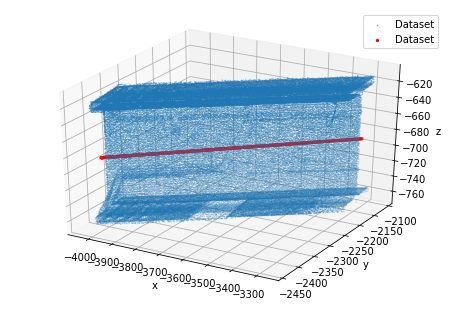

In [3]:
#分割数
n = 20
print("分割数n: %d" %(n))


#中心線描写、定義
def center_line(lexyz, ixyz, G, V_std, n):

    #直線の方程式：x/a = y/b = z/c　を用いる
    arasa = lexyz[np.argmax(lexyz)] / (50*n)
    
    #法線ベクトルを直線に拡張（点群として）
    if np.argmax(lexyz) == 0:
        d = np.arange(int(ixyz[1]), int(ixyz[0]), arasa)
        #print(d)
        st_pcd = np.zeros((len(d), 3))

        for i in range(len(d)):
            st_pcd[i] = [d[i], (d[i] - G[0])*V_std[1]/V_std[0] + G[1], (d[i] - G[0])*V_std[2]/V_std[0] + G[2]]

    elif np.argmax(lexyz) == 1:
        d = np.arange(int(ixyz[3]), int(ixyz[2]), arasa)
        st_pcd = np.zeros((len(d), 3))

        for i in range(len(d)):
            st_pcd[i] = [d[i], (d[i] - G[0])*V_std[1]/V_std[0] + G[1], (d[i] - G[0])*V_std[2]/V_std[0] + G[2]]


    elif np.argmax(lexyz) == 2:
        d = np.arange(int(ixyz[5]), int(ixyz[4]), arasa)
        st_pcd = np.zeros((len(d), 3))

        for i in range(len(d)):
            st_pcd[i] = [d[i], (d[i] - G[0])*V_std[1]/V_std[0] + G[1], (d[i] - G[0])*V_std[2]/V_std[0] + G[2]]

    return st_pcd, d


st_pcd, d = center_line(lexyz, ixyz, G, V_std, n)


st_pcdt = st_pcd.T
#print(st_pcdt)

#グラフ描写
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.scatter3D(x, y, z, label="Dataset", s=0.1)
ax1.scatter3D(st_pcdt[0], st_pcdt[1], st_pcdt[2], label="Dataset", s=5, color='red')
plt.legend()
plt.show()   


重心Gn：
[[-4007.41895135 -2386.10068527  -690.45842677]
 [-3975.95928272 -2376.40759188  -690.80890832]
 [-3937.24923833 -2364.39124408  -689.07455141]
 [-3898.88126336 -2352.5594725   -689.01072523]
 [-3860.69439239 -2340.66500871  -690.30566767]
 [-3822.42452836 -2329.04388392  -689.09404196]
 [-3784.29900104 -2317.49521384  -690.1699173 ]
 [-3747.01257701 -2305.71040227  -683.51706233]
 [-3707.8319018  -2293.24007634  -676.97125531]
 [-3669.64961939 -2281.84714069  -676.74565228]
 [-3630.76773419 -2269.38274756  -684.04242564]
 [-3592.88411088 -2257.99745803  -686.41645298]
 [-3554.65537111 -2246.16551715  -686.76372257]
 [-3516.29680415 -2234.23409428  -686.89839156]
 [-3478.10977982 -2222.81314518  -687.86573308]
 [-3439.76596727 -2211.17366679  -686.89759301]
 [-3401.76161436 -2199.16782801  -683.48900145]
 [-3363.20004243 -2188.22066509  -677.77948259]
 [-3325.07214144 -2176.87460841  -674.85659126]
 [-3291.09924682 -2163.97716429  -673.21058737]]


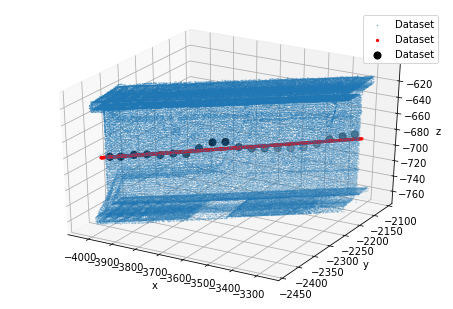

In [4]:
#輪切りにした時の各点群の重心Gnを求める

#分割数
# n = 20
# print("分割数n: %d" %(n))

Gn = np.zeros((n, 3))

for i in range(n):
    xo, yo, zo =  st_pcd[int(len(d)*(i + 1)/n - len(d)/(2*n))]
    #ddは各平面までの最大距離の二乗
    dd = (st_pcd[int(len(d)*i/n)][0] - xo)**2 + (st_pcd[int(len(d)*i/n)][1] - yo)**2 + (st_pcd[int(len(d)*i/n)][2] - zo)**2
    nn = 0 #検出した点の数(初期化)
    
    #dd > (axo + byo + czo + d)^2 / a^2 + b^2 + c^2 を満たす点(xo, yo, zo)を検出する
    for j in range(N):
        ddi = (V_std[0]*(x[j] - xo) + V_std[1]*(y[j] - yo) + V_std[2]*(z[j] - zo))**2 / (V_std[0]**2 + V_std[1]**2 + V_std[2]**2)
        
        if dd > ddi:
            Gn[i] += [x[j], y[j], z[j]]
            nn += 1
            
    Gn[i] /= nn

print("\n重心Gn：")
print(Gn)

#グラフ表示
GnT = Gn.T
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.scatter3D(x, y, z, label="Dataset", s=0.1)
ax1.scatter3D(st_pcdt[0], st_pcdt[1], st_pcdt[2], label="Dataset", s=5, color='red')
ax1.scatter3D(GnT[0], GnT[1], GnT[2], label="Dataset", s=50, color='black')
plt.legend()
plt.show()

距離パラメータ:
2.114233219391615

V[1]:
[-2.94558928e-01  9.55632873e-01  9.21915408e-04]
[[-2.94558928e-01  9.55632873e-01  9.21915408e-04]
 [-1.45311013e-02 -5.44358632e-03  9.99879600e-01]
 [ 9.55522833e-01  2.94510067e-01  1.54898550e-02]]

断面構成点数: 368


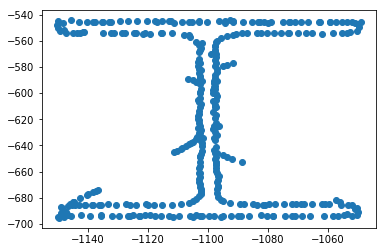

In [5]:
#領域基準面における二次元座標に変換する

#断面を構成させる点群の薄さ
Thinness = 20
#点との最大距離を決定するパラメータ
Ds = np.linalg.norm(lexyz)/(n*Thinness)
print("距離パラメータ:")
print(Ds)

#基準となる系(V)を右手座標系に変換(yを再変換)
#x = y * z
V[w[0]] = np.cross(V[w[1]], V[w[2]])

print("\nV[%d]:" %(w[0]))
print(V[w[0]])
#print(np.linalg.norm(V[0])) #単位ベクトルか確認

Q = np.array([V[w[0]], V[w[1]], V[w[2]]])

print(Q)

def sectional_pcd(Q, V_std, x, y, z, n, st_pcd):

    Sp = np.zeros((0, 2)) #二次元断面点群(座標変換後)　<-- 断面ごとの点群を扱えるように最終的には3次元配列にする

    #以下繰り返し===============================================================================================================================

    #ある断面について(何分割目のものか)
    dz = 5
    xo, yo, zo = st_pcd[int(len(st_pcd)*dz/n)] #この点を通る断面を考える


    #断面近郊の点を集める
    for i in range(N):
#         Nddi = np.sqrt((V_std[0]*(x[i] - xo) + V_std[1]*(y[i] - yo) + V_std[2]*(z[i] - zo))**2) / np.sqrt((V_std[0]**2 + V_std[1]**2 + V_std[2]**2)) #平面との距離
        Nddi = np.sqrt((V_std[0]*(x[i] - xo) + V_std[1]*(y[i] - yo) + V_std[2]*(z[i] - zo))**2) #平面との距離
        if Nddi < Ds: #拾ってくる点の範囲を決定（デフォルトは最大距離を分割数*30で割った値)

                XYZ = np.dot(Q, [[x[i]], [y[i]],[z[i]]])  #座標変換
                XY = np.array([XYZ[0][0], XYZ[1][0]])

                Sp = np.append(Sp, [XY], axis=0)

    #============================================================================================================================================

    Spt = Sp.T

    print("\n断面構成点数: %d" %(len(Sp)))
    #print("断面点群Sp:")
    #print(Sp)

    plt.scatter(Spt[0], Spt[1])
    
    return Sp, Spt, xo, yo, zo


Sp, Spt, xo, yo, zo = sectional_pcd(Q, V_std, x, y, z, n, st_pcd)


断面構成点数Sp1: 360

断面構成点数Sp2: 362


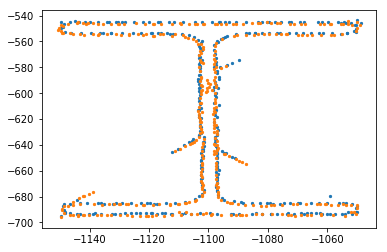

In [6]:
#領域断面の再帰的な中心線フィッティングのための断面を２つ構成

#この領域断面は領域断面の重心間のベクトルを中心差分近似を用いて中心線にするために必要なものである。
#具体的に、ここでは前後僅かに動かした断面点群データを作成する。

Sp1 = np.zeros((0,2)) #断面ごとの点群を扱えるように最終的には3次元配列にする
Sp2 = np.zeros((0,2)) #断面ごとの点群を扱えるように最終的には3次元配列にする

#以下断面ごとに繰り返し===========================================================================================================

#一つ手前の断面について
dz = 4
x1, y1, z1 = st_pcd[int(len(st_pcd)*dz/n)]
Z1 = np.dot(Q, [[x1],[y1],[z1]])[2][0] #系におけるZ座標

#断面近郊の点を集める
for i in range(N):
    Nddi = np.sqrt((V[w[2]][0]*(x[i] - x1) + V[w[2]][1]*(y[i] - y1) + V[w[2]][2]*(z[i] - z1))**2) / np.sqrt((V[w[2]][0]**2 + V[w[2]][1]**2 + V[w[2]][2]**2)) #平面との距離
    
    if Nddi < Ds: 
            XYZ = np.dot(Q, [[x[i]], [y[i]],[z[i]]])  #座標変換
            XY = np.array([XYZ[0][0], XYZ[1][0]])

            Sp1 = np.append(Sp1, [XY], axis=0)

            
#一つ後ろの断面について
dz = 6
x2, y2, z2 = st_pcd[int(len(st_pcd)*dz/n)]
Z2 = np.dot(Q, [[x2],[y2],[z2]])[2][0] #系におけるZ座標

#断面近郊の点を集める
for i in range(N):
    Nddi = np.sqrt((V[w[2]][0]*(x[i] - x2) + V[w[2]][1]*(y[i] - y2) + V[w[2]][2]*(z[i] - z2))**2) / np.sqrt((V[w[2]][0]**2 + V[w[2]][1]**2 + V[w[2]][2]**2)) #平面との距離
    
    if Nddi < Ds: 
            XYZ = np.dot(Q, [[x[i]], [y[i]],[z[i]]])  #座標変換
            XY = np.array([XYZ[0][0], XYZ[1][0]])
            
            Sp2 = np.append(Sp2, [XY], axis=0)  

#=================================================================================================================================

Sp1t = Sp1.T
Sp2t = Sp2.T

print("\n断面構成点数Sp1: %d" %(len(Sp1)))
#print("断面点群Sp1:")
#print(Sp)
plt.scatter(Sp1t[0], Sp1t[1], s=5)

print("\n断面構成点数Sp2: %d" %(len(Sp2)))
#print("断面点群Sp1:")
#print(Sp)
plt.scatter(Sp2t[0], Sp2t[1], s=5)

In [7]:
#点と線分の距離を計算する関数
def distance(a, b, xy):
    #a, b は線分終始点配列
    d = b - a
    #線分のベクトル方程式:　a + td のtを求める
    t = np.dot((xy - a), d) / (np.linalg.norm(d)**2)
    
    #tに応じて、距離の二乗を求める
    if(t <= 0):
        ss = np.linalg.norm(xy - a)**2
    elif(0 < t and t < 1):
        ss = np.linalg.norm(xy - (a + d*t))**2
    elif(1 <= t):
        ss = np.linalg.norm(xy - b)**2
    
    return ss


#多変量最適化のための目的関数
def obj_func(p, pxy):
    #パラメータ: p = [Gx, Gy, h, Θ, α, β] pxy = [[x, y], bo]
    
    xyo = pxy[0]
    bo = pxy[1]
    SS = 0
    
    q, r = (bo/2)*np.cos(p[4]), (bo/2)*np.sin(p[4])
    s, t = (bo/2)*np.cos(p[5]), (bo/2)*np.sin(p[5])
      
    E = np.array([p[0] - (p[2]/2)*np.sin(p[3]), p[1] - (p[2]/2)*np.cos(p[3])])
    F = np.array([p[0] + (p[2]/2)*np.sin(p[3]), p[1] + (p[2]/2)*np.cos(p[3])])
    A = np.array([F[0] - q, F[1] + r])
    B = np.array([F[0] + q, F[1] - r])
    
    
    
    C = np.array([E[0] - s, E[1] + t])
    D = np.array([E[0] + s, E[1] - t])
    
    
    #ベクトル線分I, II, III の終始点行列を作成
    I = np.array([[E, F],
                  [A, B],
                  [C, D]])
    
    #各点においてベクトル線分の距離の二乗を計算し、その中で最小の値をSSに足す
    for j in range(len(xyo)):
        xy = xyo[j]
        ss = np.zeros(3)
        
        for i in range(3):
            
            #a, b は線分終始点配列
            a, b = I[i][0], I[i][1]
            d = b - a
            
            #線分のベクトル方程式:　a + td のtを求める
            t = np.dot((xy - a), d) / (np.linalg.norm(d)**2)

            #tに応じて、距離の二乗を求める
            if(t <= 0):
                ss[i] = np.linalg.norm(xy - a)**2
            elif(0 < t and t < 1):
                ss[i] = np.linalg.norm(xy - (a + d*t))**2
            elif(1 <= t):
                ss[i] = np.linalg.norm(xy - b)**2
            
        SS += np.min(ss)
    
    return SS

In [8]:
#パラメータの最適化
from scipy.optimize import minimize

#パラメータ初期値の設定　p = [Gx, Gy, h, rad] pxy = [x, y]
p = np.array([np.average(Spt[0]), np.average(Spt[1]), np.abs(np.max(Spt[1]) - np.min(Spt[1])), 0, 0, 0])
bo = np.abs(int(np.max(Spt[0]) - np.min(Spt[0])))


print("\n=========== パラメータ初期値　=========== ")
print("重心点 : ( %.4f, %.4f )" %(p[0], p[1]))
print("高さ : %.4f" %(p[2]))
print("座標軸との傾き : 0[rad]")
print("ウェブと上フランジの傾き : 0.5π[rad]")
print("ウェブと下フランジの傾き : 0.5π[rad]")

print("幅（固定）: %d" %(bo))
print("==========================================")

#最適化
arg = np.array([Sp, bo])
P = minimize(obj_func, p, args=arg, method="powell")


#print(P)

print("\n================ 最適化　=============== ")
print("断面: (%.4f, %.4f, %.4f) "%(xo, yo, zo))
print("重心点 : ( %.4f, %.4f )" %(P.x[0], P.x[1]))
print("高さ : %.4f" %(P.x[2]))
print("座標軸との傾き : %.4f[rad]" %(P.x[3]))
print("ウェブと上フランジの傾き : %.4fπ[rad]" %(0.5 + P.x[4]/np.pi))
print("ウェブと下フランジの傾き : %.4fπ[rad]" %(0.5 - P.x[5]/np.pi))
print("幅（固定）: %d" %(bo))
print("==========================================")

#Sp1の最適化
p1 = np.array([np.average(Sp1t[0]), np.average(Sp1t[1]), np.abs(np.max(Sp1t[1]) - np.min(Sp1t[1])), 0, 0, 0])
b1 = np.abs(int(np.max(Sp1t[0]) - np.min(Sp1t[0])))
arg1 = np.array([Sp1, b1])

P1 = minimize(obj_func, p1, args=arg1, method="powell")
print("\n================ Sp1最適化　=============== ")
print("断面: (%.4f, %.4f, %.4f) "%(x1, y1, z1))
print("重心点 : ( %.4f, %.4f )" %(P1.x[0], P1.x[1]))
print("高さ : %.4f" %(P1.x[2]))
print("座標軸との傾き : %.4f[rad]" %(P1.x[3]))
print("ウェブと上フランジの傾き : %.4fπ[rad]" %(0.5 + P1.x[4]/np.pi))
print("ウェブと下フランジの傾き : %.4fπ[rad]" %(0.5 - P1.x[5]/np.pi))
print("幅（固定）: %d" %(b1))
print("==========================================")

#Sp2の最適化
p2 = np.array([np.average(Sp2t[0]), np.average(Sp2t[1]), np.abs(np.max(Sp2t[1]) - np.min(Sp2t[1])), 0, 0, 0])
b2 = np.abs(int(np.max(Sp2t[0]) - np.min(Sp2t[0])))
arg2 = np.array([Sp2, b2])

P2 = minimize(obj_func, p2, args=arg2, method="powell")
print("\n================ Sp2最適化　=============== ")
print("断面: (%.4f, %.4f, %.4f) "%(x2, y2, z2))
print("重心点 : ( %.4f, %.4f )" %(P2.x[0], P2.x[1]))
print("高さ : %.4f" %(P2.x[2]))
print("座標軸との傾き : %.4f[rad]" %(P2.x[3]))
print("ウェブと上フランジの傾き : %.4fπ[rad]" %(0.5 + P2.x[4]/np.pi))
print("ウェブと下フランジの傾き : %.4fπ[rad]" %(0.5 - P2.x[5]/np.pi))
print("幅（固定）: %d" %(b2))
print("==========================================")




=========== パラメータ初期値　=========== 
重心点 : ( -1101.6179, -621.7322 )
高さ : 151.1383
座標軸との傾き : 0[rad]
ウェブと上フランジの傾き : 0.5π[rad]
ウェブと下フランジの傾き : 0.5π[rad]
幅（固定）: 101

================ 最適化　=============== 
断面: (-3841.6586, -2334.8825, -688.1022) 
重心点 : ( -1100.2055, -619.0947 )
高さ : 139.8968
座標軸との傾き : 0.0032[rad]
ウェブと上フランジの傾き : 0.4979π[rad]
ウェブと下フランジの傾き : 0.4940π[rad]
幅（固定）: 101

================ Sp1最適化　=============== 
断面: (-3879.9269, -2346.6775, -688.7225) 
重心点 : ( -1099.8998, -619.2799 )
高さ : 140.8743
座標軸との傾き : 0.0015[rad]
ウェブと上フランジの傾き : 0.5009π[rad]
ウェブと下フランジの傾き : 0.5004π[rad]
幅（固定）: 101

================ Sp2最適化　=============== 
断面: (-3803.3903, -2323.0875, -687.4818) 
重心点 : ( -1100.0123, -619.8412 )
高さ : 139.8160
座標軸との傾き : -0.0130[rad]
ウェブと上フランジの傾き : 0.4963π[rad]
ウェブと下フランジの傾き : 0.4968π[rad]
幅（固定）: 101


(array([-1150.48248944,  -549.48393638]), array([-1049.48474245,  -548.80932441]), array([-1150.91861562,  -688.09741763]), array([-1049.9363111 ,  -689.98796634]), array([-1100.42746336,  -689.04269199]), array([-1099.98361594,  -549.1466304 ]))


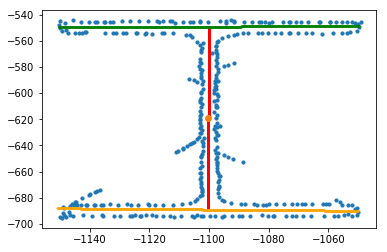

In [9]:
#結果と断面点群のプロット
def sectional_result_plot(P, bo):
    komakasa = 1000

    q, r = (bo/2)*np.cos(P.x[4]), (bo/2)*np.sin(P.x[4])
    s, t = (bo/2)*np.cos(P.x[5]), (bo/2)*np.sin(P.x[5])

    E = np.array([P.x[0] - (P.x[2]/2)*np.sin(P.x[3]), P.x[1] - (P.x[2]/2)*np.cos(P.x[3])])
    F = np.array([P.x[0] + (P.x[2]/2)*np.sin(P.x[3]), P.x[1] + (P.x[2]/2)*np.cos(P.x[3])])
    A = np.array([F[0] - q, F[1] + r])
    B = np.array([F[0] + q, F[1] - r])
    C = np.array([E[0] - s, E[1] + t])
    D = np.array([E[0] + s, E[1] - t])


    #ベクトル方程式 -->  [x, y] = a + t*(b - a)
    Iy = np.arange(E[1], F[1], (F[1] - E[1])/komakasa)
    IIx = np.arange(A[0], B[0],(B[0] - A[0])/komakasa)
    IIIx = np.arange(C[0], D[0], (D[0] - C[0])/komakasa)


    leI, leII, leIII = len(Iy), len(IIx), len(IIIx)
    I, II, III = np.zeros((leI, 2)), np.zeros((leII, 2)), np.zeros((leIII, 2))

    #print(leI, leII, leIII)
    for i in range(leI):
        I[i][0] = E[0] + (i / leI)*(F[0] - E[0])
        I[i][1] = Iy[i]
    for i in range(leII):
        II[i][0] = IIx[i]
        II[i][1] = A[1] + (i / leII)*(B[1] - A[1])

    for i in range(leIII):
        III[i][0] = IIIx[i]
        III[i][1] = C[1] +(i / leIII)*(D[1] - C[1])    

    It = I.T
    IIt = II.T
    IIIt = III.T
    

#     plt.xlim(-1200, -1000) # x軸の表示範囲
#     plt.ylim(-780, -720)
    plt.scatter(Spt[0], Spt[1], s=10)
    plt.scatter(It[0], It[1], s=1, color="red")
    plt.scatter(IIt[0], IIt[1], s=1, color="green")
    plt.scatter(IIIt[0], IIIt[1], s=1, color="orange")
    plt.scatter(P.x[0], P.x[1])
#     plt.scatter(P1.x[0], P1.x[1], s=20)
#     plt.scatter(P2.x[0], P2.x[1], s=10)

    return(A, B, C, D, E, F)

A = sectional_result_plot(P, bo)
print(A)

plt.xlim(-1108, -1100) #x軸の表示範囲
plt.ylim(-760, -720)
plt.scatter(Spt[0], Spt[1], s=10)
plt.scatter(It[0], It[1], s=1)
plt.scatter(IIt[0], IIt[1], s=1)
plt.scatter(IIIt[0], IIIt[1], s=1)
plt.scatter(P.x[0], P.x[1])
plt.scatter(P1.x[0], P1.x[1])
plt.scatter(P2.x[0], P2.x[1])

隣り合う重心点：
[[-3880.05656682]
 [-2346.26748614]
 [ -688.51641975]]
[[-3803.4787106 ]
 [-2322.78189889]
 [ -687.83702233]]

新たな主軸：
[0.95601383 0.29319894 0.00848174]

元の主軸との角度:
0.002275π [rad]
0.409471 [度]


新たな座標系（仮）:
[[ 9.56013830e-01  2.93198939e-01  8.48173817e-03]
 [-2.93216642e-01  9.56044537e-01  9.33824151e-04]
 [-7.83512320e-03 -3.37973559e-03  9.99962608e-01]]

断面構成点数: 360

================ rSp最適化　=============== 
断面: (-3841.6586, -2334.8825, -688.1022) 
重心点 : ( -1100.1243, -619.3774 )
高さ : 139.9706
座標軸との傾き : 0.0005[rad]
ウェブと上フランジの傾き : 0.4976π[rad]
ウェブと下フランジの傾き : 0.4949π[rad]
幅（固定）: 101

A配列の中身:
(array([-1150.58808377,  -549.7749341 ]), array([-1049.59098683,  -549.0091606 ]), array([-1150.65276125,  -688.56052905]), array([-1049.66550343,  -690.16482224]), array([-1100.15913234,  -689.36267564]), array([-1100.0895353 ,  -549.39204735]))


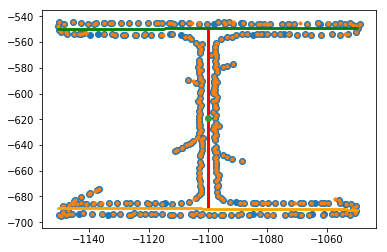

In [10]:
#新たな中心線を定義し、再フィッティング

Q_inv = np.linalg.inv(Q)
# print(Q)

#元の座標軸に座標を戻す
#Sp1, Sp2の重心点（ｘｙｚ）
G1 = np.dot(Q_inv, [[P1.x[0]],[P1.x[1]],[Z1]])
G2 = np.dot(Q_inv, [[P2.x[0]],[P2.x[1]],[Z2]])
print("隣り合う重心点：")
print(G1)
print(G2)

L = (G2 - G1)/np.linalg.norm(G2 - G1) #新たな主軸単位ベクトル
L = np.array([L[0][0], L[1][0], L[2][0]])
print("\n新たな主軸：")
print(L)
print("\n元の主軸との角度:")
print("%.6fπ [rad]" %(np.arccos(np.dot(V_std, L))/np.pi))
print("%.6f [度]" %(np.arccos(np.dot(V_std, L))*360/(2*np.pi)))
print("\n")


#新たな座標系の定義（仮）
rV = np.zeros((3,3))
rV[w[1]] = np.cross(L, V[w[0]])
rV[w[0]] = np.cross(rV[w[1]], L)
rV[w[2]] = L
print("新たな座標系（仮）:")
print(rV)

rQ = np.array([V[w[0]], V[w[1]], V[w[2]]])
rSp, rSpt, rxo, ryo, rzo = sectional_pcd(rQ, rV[w[2]], x, y, z, n, st_pcd)

#再最適化
rp = np.array([np.average(rSpt[0]), np.average(rSpt[1]), np.abs(np.max(rSpt[1]) - np.min(rSpt[1])), 0, 0, 0])
rb = np.abs(int(np.max(rSpt[0]) - np.min(rSpt[0])))
rarg = np.array([rSp, rb])

rP = minimize(obj_func, rp, args=rarg, method="powell")
print("\n================ rSp最適化　=============== ")
print("断面: (%.4f, %.4f, %.4f) "%(rxo, ryo, rzo))
print("重心点 : ( %.4f, %.4f )" %(rP.x[0], rP.x[1]))
print("高さ : %.4f" %(rP.x[2]))
print("座標軸との傾き : %.4f[rad]" %(rP.x[3]))
print("ウェブと上フランジの傾き : %.4fπ[rad]" %(0.5 + rP.x[4]/np.pi))
print("ウェブと下フランジの傾き : %.4fπ[rad]" %(0.5 - rP.x[5]/np.pi))
print("幅（固定）: %d" %(rb))
print("==========================================")

A = sectional_result_plot(rP, rb)
print("\nA配列の中身:")
print(A)
# np.savetxt("rSp.xyz", [rxo, ryo, rzo])
# np.savetxt("excenter.xyz", rst_pcd)


#オイラー角
# Ox = np.arctan(-L[1]/L[2])
# Oy = np.arctan(-L[2]/L[0])
# Oz = np.arctan(-L[0]/L[1])
# print(Ox, Oy, Oz)

# rz = np.array([[np.cos(Oz) ,-np.sin(Oz) ,0          ],
#                [np.sin(Oz),np.cos(Oz) ,0          ],
#                [0          ,0          ,1          ]])

# rx = np.array([[1          ,0          ,0          ],
#                [0          ,np.cos(Ox) ,-np.sin(Ox) ],
#                [0          ,np.sin(Ox),np.cos(Ox)]])

# ry = np.array([[np.cos(Oy) ,0          ,np.sin(Oy)],
#                [0          ,1          ,0          ],
#                [-np.sin(Oy) ,0          ,np.cos(Oy) ]])

# fig = plt.figure()
# ax1 = Axes3D(fig)
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')

# ax1.scatter3D(rVpt[1], rVpt[2], rVpt[0], label="Dataset", s=0.1)
# ax1.scatter3D(Lpcdt[1], Lpcdt[2], Lpcdt[0], label="Dataset", s=5, color='red')
# plt.legend()
# plt.show()   

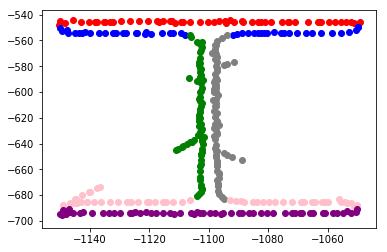

In [17]:
class group:
    gI = np.zeros((0,2))
    gII = np.zeros((0,2))
    gIII = np.zeros((0,2))
    gp1, gp2, gp3, gp4, gp5, gp6 = np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2))
    gp1d, gp2d, gp3d, gp4d, gp5d, gp6d = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
    
#点群をグルーピング(gI, gII, gIII)
gI = np.zeros((0,2))
gII = np.zeros((0,2))
gIII = np.zeros((0,2))

#ベクトル線分I, II, III の終始点行列を作成
I = np.array([[A[4], A[5]],
              [A[0], A[1]],
              [A[2], A[3]]])

#ベクトル線分
Ic = np.array([A[5] - A[4], A[1] - A[0], A[3] - A[2]])
# print(Ic)

#各点においてベクトル線分の距離の二乗を計算
for i in range(len(rSp)):
    xy = rSp[i]
    ss = np.zeros(3)
        
    for i in range(3):
            
        #a, b は線分終始点配列
        a, b = I[i][0], I[i][1]
        d = b - a
            
        #線分のベクトル方程式:　a + td のtを求める
        t = np.dot((xy - a), d) / (np.linalg.norm(d)**2)

        #tに応じて、距離の二乗を求める
        if(t <= 0):
            ss[i] = np.linalg.norm(xy - a)**2
        elif(0 < t and t < 1):
            ss[i] = np.linalg.norm(xy - (a + d*t))**2
        elif(1 <= t):
            ss[i] = np.linalg.norm(xy - b)**2
    
    #グルーピング
    if np.argmin(ss) == 0:
        gI = np.append(gI, [xy], axis=0)
    if np.argmin(ss) == 1:
        gII = np.append(gII, [xy], axis=0)
    if np.argmin(ss) == 2:
        gIII = np.append(gIII, [xy], axis=0)
        
#確認
# gIt = gI.T
# gIIt = gII.T
# gIIIt = gIII.T
# plt.scatter(gIt[0], gIt[1], color="red")
# plt.scatter(gIIt[0], gIIt[1], color="green")
# plt.scatter(gIIIt[0], gIIIt[1], color="blue")


#さらに細かくグルーピング(gp)
gp1, gp2, gp3, gp4, gp5, gp6 = np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2)),np.zeros((0,2))
#ついでに各点の線分との距離を計算しておく（gpd)
gp1d, gp2d, gp3d, gp4d, gp5d, gp6d = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)


def distance_cal(a, b, xy):
    d = b - a
#   線分のベクトル方程式:　a + td のtを求める
    t = np.dot((xy - a), d) / (np.linalg.norm(d)**2)
    
    return np.linalg.norm(xy - (a + d*t))**2

        
for i in range(len(gI)):
    
    gd = distance_cal(I[0][0],  I[0][1], gI[i])
    
    if np.cross(Ic[0], gI[i] - A[4]) >= 0:
        gp3 = np.append(gp3, [gI[i]], axis=0)
        gp3d = np.append(gp3d, [gd])
    else:
        gp4 = np.append(gp4, [gI[i]], axis=0)
        gp4d = np.append(gp4d, [gd])
        
for i in range(len(gII)):
      
    gd = distance_cal(I[1][0],  I[1][1], gII[i])
    
    if np.cross(Ic[1], gII[i] - A[0]) >= 0:
        gp1 = np.append(gp1, [gII[i]], axis=0)
        gp1d = np.append(gp1d, [gd])
    else:
        gp2 = np.append(gp2, [gII[i]], axis=0)  
        gp2d = np.append(gp2d, [gd])
        
for i in range(len(gIII)):
    
    gd = distance_cal(I[2][0],  I[2][1], gIII[i])
    
    if np.cross(Ic[2], gIII[i] - A[2]) >= 0:
        gp5 = np.append(gp5, [gIII[i]], axis=0)
        gp5d = np.append(gp5d, [gd])
    else:
        gp6 = np.append(gp6, [gIII[i]], axis=0) 
        gp6d = np.append(gp6d, [gd])
    

gp = np.array([gp1, gp2, gp3, gp4, gp5, gp6])
gpd = np.array([gp1d, gp2d, gp3d, gp4d, gp5d, gp6d])
# print(gpd)

#確認
gp1t = gp1.T
gp2t = gp2.T
gp3t = gp3.T
gp4t = gp4.T
gp5t = gp5.T
gp6t = gp6.T

plt.scatter(gp1t[0], gp1t[1], color="red")
plt.scatter(gp2t[0], gp2t[1], color="blue")
plt.scatter(gp3t[0], gp3t[1], color="green")
plt.scatter(gp4t[0], gp4t[1], color="grey")
plt.scatter(gp5t[0], gp5t[1], color="pink")
plt.scatter(gp6t[0], gp6t[1], color="purple")

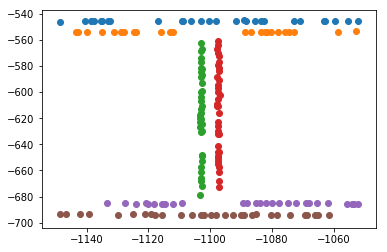

In [12]:
# 外れ値を除外する（四分位範囲の点を有効）

# 距離順にソートし四分位範囲を抜き取る関数
def quart_range(p, d):
    sp =  np.zeros((0, 2))
#     median = d[np.argsort(d)[int(len(d)/2)]]
#     d = np.abs(d - median)
    sidx = np.argsort(d)
    
    for j in sidx[int(len(sidx)*1/4):int(len(sidx)*3/4)]:
        sp = np.append(sp, [p[j]], axis=0)
    
    return sp

gps = np.array([quart_range(gp[0], gpd[0]), quart_range(gp[1], gpd[1]), quart_range(gp[2], gpd[2]), quart_range(gp[3], gpd[3]), quart_range(gp[4], gpd[4]), quart_range(gp[5], gpd[5])])

# print(gpds)
gp1t = gps[0].T
gp2t = gps[1].T
gp3t = gps[2].T
gp4t = gps[3].T
gp5t = gps[4].T
gp6t = gps[5].T
plt.scatter(gp1t[0], gp1t[1])
plt.scatter(gp2t[0], gp2t[1])
plt.scatter(gp3t[0], gp3t[1])
plt.scatter(gp4t[0], gp4t[1])
plt.scatter(gp5t[0], gp5t[1])
plt.scatter(gp6t[0], gp6t[1])   

In [13]:
#各点群が構成する直線を最小二乗法で求める
#対となる線分の傾きはここで統一させる

def obj_func_flange(ps, xyxy):
    # y = ax + b, y = ax + c　において
    #パラメータps = [a, b, c], xyxy = [[xy],[xy]]の三次元配列
    xy1 = xyxy[0]
    xy2 = xyxy[1]
    Ss = 0

    for i in range(len(xy1)):
        Ss += (ps[0]*xy1[i][0] + ps[1] - xy1[i][1])**2
    
    for i in range(len(xy2)):
        Ss += (ps[0]*xy2[i][0] + ps[2] - xy2[i][1])**2
        
    return Ss


def obj_func_web(ps, xyxy):
    # x = ay + b, x = ay + c　において
    #パラメータps = [a, b, c], xyxy = [[xy],[xy]]の三次元配列
    xy1 = xyxy[0]
    xy2 = xyxy[1]
    Ss = 0

    for i in range(len(xy1)):
        Ss += (ps[0]*xy1[i][1] + ps[1] - xy1[i][0])**2
    
    for i in range(len(xy2)):
        Ss += (ps[0]*xy2[i][1] + ps[2] - xy2[i][0])**2
        
    return Ss


#II初期値
ds = (A[1][1] - A[0][1])/(A[1][0] - A[0][0])
ps = np.array([ds, A[0][1] - ds*A[0][0], A[0][1] - ds*A[0][0]])

PsII = minimize(obj_func_flange, ps, args=[gps[0],gps[1]], method="powell")


#I初期値
ds = (A[5][0] - A[4][0])/(A[5][1] - A[4][1])
ps = np.array([ds, A[4][0] - ds*A[4][1], A[4][0] - ds*A[4][1]])

PsI = minimize(obj_func_web, ps, args=[gps[2],gps[3]], method="powell")


#III初期値
ds = (A[4][1] - A[3][1])/(A[4][0] - A[3][0])
ps = np.array([ds, A[3][1] - ds*A[3][0], A[3][1] - ds*A[3][0]])

PsIII = minimize(obj_func_flange, ps, args=[gps[4],gps[5]], method="powell")


#結果
print("=============結果==============")
print("I': x = %.3fy + %.3f" %(PsI.x[0], PsI.x[1]))
print("I'': x = %.3fy + %.3f" %(PsI.x[0], PsI.x[2]))
print("II': y = %.3fx + %.3f" %(PsII.x[0], PsII.x[1]))
print("II'': y = %.3fx + %.3f" %(PsII.x[0], PsII.x[2]))
print("III': y = %.3fx + %.3f" %(PsIII.x[0], PsIII.x[1]))
print("III'': y = %.3fx + %.3f" %(PsIII.x[0], PsIII.x[2]))
print("==============================")


=============結果==============
I': x = 0.002y + -1105.042
I'': x = 0.002y + -1099.502
II': y = -0.003x + -675.208
II'': y = -0.003x + -683.706
III': y = -0.010x + -822.604
III'': y = -0.010x + -831.201


In [14]:
#フランジの厚さを統一する

#フランジの厚さの平均
L = (np.abs(PsII.x[1] - PsII.x[2])*np.cos(np.arctan(PsII.x[0])) + np.abs(PsIII.x[1] - PsIII.x[2])*np.cos(np.arctan(PsIII.x[0])))/2
# print(np.abs(PsII.x[1] - PsII.x[2]))
# print(np.abs(PsIII.x[1] - PsIII.x[2]))
# print(np.abs(PsII.x[1] - PsII.x[2])*np.cos(np.arctan(PsII.x[0])))
# print(np.abs(PsIII.x[1] - PsIII.x[2])*np.cos(np.arctan(PsIII.x[0])))
print("フランジ厚さ：")
print(L)

#フランジの厚さが平均になるように線分を平行移動
dyII = (L / np.cos(np.arctan(PsII.x[0]))) - np.abs(PsII.x[1] - PsII.x[2]) 
dyIII = (L / np.cos(np.arctan(PsIII.x[0]))) - np.abs(PsIII.x[1] - PsIII.x[2]) 
PsII.x[1] += dyII/2 
PsII.x[2] -= dyII/2
PsIII.x[1] += dyIII/2
PsIII.x[2] -= dyIII/2

# print(np.abs(PsII.x[1] - PsII.x[2]))
# print(np.abs(PsIII.x[1] - PsIII.x[2]))

#結果
print("\n=============結果=============")
print("I': x = %.3fy + %.3f" %(PsI.x[0], PsI.x[1]))
print("I'': x = %.3fy + %.3f" %(PsI.x[0], PsI.x[2]))
print("II': y = %.3fx + %.3f" %(PsII.x[0], PsII.x[1]))
print("II'': y = %.3fx + %.3f" %(PsII.x[0], PsII.x[2]))
print("III': y = %.3fx + %.3f" %(PsIII.x[0], PsIII.x[1]))
print("III'': y = %.3fx + %.3f" %(PsIII.x[0], PsIII.x[2]))
print("==============================")


フランジ厚さ：
8.546758907365572

=============結果=============
I': x = 0.002y + -1105.042
I'': x = 0.002y + -1099.502
II': y = -0.003x + -675.183
II'': y = -0.003x + -683.730
III': y = -0.010x + -822.629
III'': y = -0.010x + -831.176


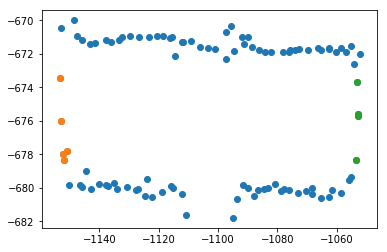

In [15]:
#フランジの横を構成する線分を特定する

# 四分位範囲を下回る点群を抜き取る関数
# def inout_quart_range(p, d):
#     sp =  np.zeros((0, 2))
#     median = d[np.argsort(d)[int(len(d)/2)]]
#     d = np.abs(d - median)
#     sidx = np.argsort(d)
    
#     for j in sidx[:int(len(sidx)*1/4)]:
#         sp = np.append(sp, [p[j]], axis=0)

#     return sp


#上フランジを構成しうる点群
# abp = np.append(inout_quart_range(gp[0], gpd[0]), inout_quart_range(gp[1], gpd[1]), axis=0)
# print(abp)
# abpt = abp.T
# plt.scatter(abpt[0], abpt[1])


#直線からの距離がL/4の範囲にあり、Iの中心線における点との最大距離×５/4以上の距離である点を抜き取りと右側の点群に分ける
def side_flange(P, Iy, Ic, a, b): #y = ax + b, yはIのyの係数、IcはＩの平均ｘ切片
    Lp = np.zeros((0,2))
    Rp = np.zeros((0,2))
    Id = np.zeros(len(P))
    Idmax = 0
    
    for i,p in enumerate(P):      
        Id[i] = np.abs(p[0] - Iy*p[1] - Ic) / np.sqrt(Iy**2 + 1)
        
        if Id[i] > Idmax:
            Idmax = Id[i]
    
    for i,p in enumerate(P):
        IId = np.abs(-a*p[0] + p[1] - b) / np.sqrt(a**2 + 1)
        
        if IId <= L/3 and Id[i] > Idmax*4/5:
            if p[1]*Iy+Ic-p[0] > 0:
                Rp = np.append(Rp, [p], axis=0)
            else:
                Lp = np.append(Lp, [p], axis=0)
    
    return Rp, Lp


#上フランジの横面を構成する点
tpLp, tpRp = side_flange(gII, PsI.x[0], (PsI.x[1] + PsI.x[2])/2, PsII.x[0], (PsII.x[1]+PsII.x[2])/2)
#下フランジの横面を構成する点
bmLp, bmRp = side_flange(gIII, PsI.x[0], (PsI.x[1] + PsI.x[2])/2, PsIII.x[0], (PsIII.x[1]+PsIII.x[2])/2)

# plt.subplot(1, 2, 1)
plt.scatter(gII.T[0], gII.T[1])
plt.scatter(tpLp.T[0], tpLp.T[1])
plt.scatter(tpRp.T[0], tpRp.T[1])
# plt.subplot(1, 2, 2)
# plt.ylim(-825, -805)
# plt.scatter(gIII.T[0], gIII.T[1])
# plt.scatter(bmLp.T[0], bmLp.T[1])
# plt.scatter(bmRp.T[0], bmRp.T[1])

In [16]:
#フランジ横の線分の方程式を最小二乗法でだす（傾きはフランジに直交で固定）

def obj_func_side_flange(c, pc):
    #x = -IId*y + c[0], x = -IId*y + c[1]　（IIdはIIの傾き,もしくはIIIの傾き)
    #pc = [[Lp], [Rp], IId]を格納する配列 (Lp, Rpは二次元点群データ)
    Lp = pc[0]
    Rp = pc[1]
    Ss = 0
    
    for lp in Lp:
        Ss += (-pc[2]*lp[1] + c[0] - lp[0])**2
    for rp in Rp:
        Ss += (-pc[2]*rp[1] + c[1] - rp[0])**2
    
    return Ss

#上フランジ
tc = np.array([tpLp[0][0], tpRp[0][0]])
Pts = minimize(obj_func_side_flange, tc, args=[tpLp, tpRp, PsII.x[0]], method="powell")    


#下フランジ
tc = np.array([bmLp[0][0], bmRp[0][0]])
Pbs = minimize(obj_func_side_flange, tc, args=[bmLp, bmRp, PsIII.x[0]], method="powell")    

#結果
print("=============結果=============")
print("IIL : x = %.3fy + %.3f" %(-PsII.x[0], Pts.x[0]))
print("IIR : x = %.3fy + %.3f" %(-PsII.x[0], Pts.x[1]))
print("IIIL : x = %.3fy + %.3f" %(-PsIII.x[0], Pbs.x[0]))
print("IIIR : x = %.3fy + %.3f" %(-PsIII.x[0], Pbs.x[1]))
print("==============================")


=============結果=============
IIL : x = 0.003y + -1150.060
IIR : x = 0.003y + -1050.697
IIIL : x = 0.010y + -1143.168
IIIR : x = 0.010y + -1046.197


In [17]:
#フランジの長さを統一する
#フランジ長さの平均
U = np.abs(((Pts.x[1] - Pts.x[0])*np.cos(np.arctan(PsII.x[0])) + (Pbs.x[1] - Pbs.x[0])*np.cos(np.arctan(PsIII.x[0]))) / 2)
print("フランジの長さ:")
print(U)
# print((Pts.x[1] - Pts.x[0])*np.cos(np.arctan(PsII.x[0])))
# print((Pbs.x[1] - Pbs.x[0])*np.cos(np.arctan(PsIII.x[0])))

#フランジの長さが平均になるように線分を平行移動
dxII = (U / np.cos(np.arctan(PsII.x[0]))) - np.abs(Pts.x[1] - Pts.x[0]) 
dxIII = (U / np.cos(np.arctan(PsIII.x[0]))) - np.abs(Pbs.x[1] - Pbs.x[0]) 
Pts.x[0] -= dxII/2 
Pts.x[1] += dxII/2
Pbs.x[0] -= dxIII/2
Pbs.x[1] += dxIII/2

# 結果
print("\n=============結果=============")
print("IIL : x = %.3fy + %.3f" %(-PsII.x[0], Pts.x[0]))
print("IIR : x = %.3fy + %.3f" %(-PsII.x[0], Pts.x[1]))
print("IIIL : x = %.3fy + %.3f" %(-PsIII.x[0], Pbs.x[0]))
print("IIIR : x = %.3fy + %.3f" %(-PsIII.x[0], Pbs.x[1]))
print("===============================")


フランジの長さ:
98.16431546160904

=============結果=============
IIL : x = 0.003y + -1149.461
IIR : x = 0.003y + -1051.296
IIIL : x = 0.010y + -1143.768
IIIR : x = 0.010y + -1045.598


In [18]:
#各線分におけるA, B, C, D, E, Fの座標値を求める

#y = [yd]*x + [yc], x = [xd]*y + [xc]の解を求める関数
def slv_equt(yd, yc, xd, xc): 
   
    y = (yc + yd*xc) / (1 - yd*xd)
    x = xd*y + xc  
    
    return x, y


vtx_p = np.zeros((12, 2))
vtx_p[0] = slv_equt(PsII.x[0], PsII.x[1], -PsII.x[0], Pts.x[0])
vtx_p[1] = slv_equt(PsII.x[0], PsII.x[2], -PsII.x[0], Pts.x[0])
vtx_p[2] = slv_equt(PsII.x[0], PsII.x[1], -PsII.x[0], Pts.x[1])
vtx_p[3] = slv_equt(PsII.x[0], PsII.x[2], -PsII.x[0], Pts.x[1])
vtx_p[4] = slv_equt(PsIII.x[0], PsIII.x[1], -PsIII.x[0], Pbs.x[0])
vtx_p[5] = slv_equt(PsIII.x[0], PsIII.x[2], -PsIII.x[0], Pbs.x[0])
vtx_p[6] = slv_equt(PsIII.x[0], PsIII.x[1], -PsIII.x[0], Pbs.x[1])
vtx_p[7] = slv_equt(PsIII.x[0], PsIII.x[2], -PsIII.x[0], Pbs.x[1])
vtx_p[8] = slv_equt(PsIII.x[0], PsIII.x[1], PsI.x[0], PsI.x[1])
vtx_p[9] = slv_equt(PsIII.x[0], PsIII.x[1], PsI.x[0], PsI.x[2])
vtx_p[10] = slv_equt(PsII.x[0], PsII.x[2], PsI.x[0], PsI.x[1])
vtx_p[11] = slv_equt(PsII.x[0], PsII.x[2], PsI.x[0], PsI.x[2])

print("頂点座標:")
print(vtx_p)

頂点座標:
[[-1151.71782981  -671.31157081]
 [-1151.74656268  -679.85828141]
 [-1053.55406908  -671.64158395]
 [-1053.58280195  -680.18829456]
 [-1152.20946402  -810.6302243 ]
 [-1152.29846333  -819.17651981]
 [-1054.05047094  -811.65243116]
 [-1054.13947024  -820.19872667]
 [-1106.26930696  -811.10863532]
 [-1100.72875053  -811.16633349]
 [-1106.07101201  -680.01183637]
 [-1100.53039648  -680.03046317]]


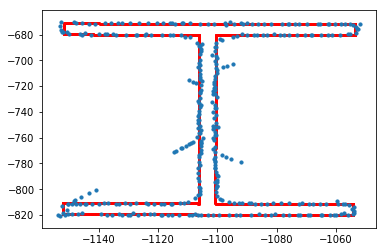

In [19]:
#頂点をもとに輪郭をプロットする

#線分を構成する点の作成
def line_segment(p1, p2): #p1, p2は始点と終点
    pN = 500
    P = np.zeros((pN, p1.shape[0]))
    
    for i in range(len(P)):
        P[i] = p1 + ((i + 1)/pN)*(p2 - p1)
    
    return P

seg_p = np.zeros((0, 2))
seg_p = np.append(seg_p, line_segment(vtx_p[0], vtx_p[1]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[2], vtx_p[3]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[4], vtx_p[5]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[6], vtx_p[7]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[8], vtx_p[10]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[9], vtx_p[11]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[0], vtx_p[2]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[1], vtx_p[10]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[11], vtx_p[3]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[4], vtx_p[8]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[9], vtx_p[6]), axis=0)
seg_p = np.append(seg_p, line_segment(vtx_p[5], vtx_p[7]), axis=0)

plt.scatter(seg_p.T[0], seg_p.T[1], s=3, color="red")
plt.scatter(rSp.T[0], rSp.T[1], s=10)
# np.savetxt("seg.xyz", seg_p)
# np.savetxt("rsp_pcd.xyz", rSp)

In [37]:
#頂点座標を元の座標系に戻す。

rZ = np.dot(rQ, [[rxo],[ryo],[rzo]])[2][0] #系におけるZ座標
print(rZ)
rQ_inv = np.linalg.inv(rQ)

# 頂点座標を元の3次元座標系に直す
vtx_xyz = np.zeros((12, 3))
for i in range(len(vtx_xyz)):
    vtx_xyz[i] = np.dot(Q_inv, [[vtx_p[i][0]],[vtx_p[i][1]],[rZ]]).T
print(vtx_xyz)

# plt.scatter(vtx_xyz.T[1], vtx_xyz.T[2])
np.savetxt("vtx.xyz", vtx_xyz)

-4348.639137737838
[[-3826.43001324 -2380.93101027  -614.30970446]
 [-3826.55393843 -2380.950589    -622.85554246]
 [-3855.34534085 -2287.12218934  -614.10531497]
 [-3855.46926604 -2287.14176807  -622.65115297]
 [-3828.44324776 -2381.27239207  -753.61426024]
 [-3828.54941745 -2381.34956377  -762.16001125]
 [-3857.36789323 -2287.46748912  -754.10200708]
 [-3857.47406292 -2287.54466082  -762.64775809]
 [-3841.98049701 -2337.37002674  -753.84253445]
 [-3843.6131404  -2332.07523569  -753.87006518]
 [-3840.00822646 -2337.30138972  -622.76044013]
 [-3841.64028204 -2332.00657821  -622.74890386]]
